In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from glicko2 import Player

In [39]:
csv_path='data/0824.csv'

In [40]:

# モデルのレーティングを保持する辞書
models = {}

# レーティング変更履歴を保存するリスト
rating_history = []

def get_or_create_player(model_name):
    if model_name not in models:
        models[model_name] = Player(rating=1500, rd=350, vol=0.06)
    return models[model_name]

def update_ratings(model1, model2, result, index):
    player1 = get_or_create_player(model1)
    player2 = get_or_create_player(model2)
    
    # 更新前のレーティングとRDを保存
    rating1, rd1 = player1.rating, player1.rd
    rating2, rd2 = player2.rating, player2.rd
    
    # result: 1 = model1の勝利, 0.5 = 引き分け, 0 = model2の勝利
    player1.update_player([rating2], [rd2], [result])
    player2.update_player([rating1], [rd1], [1 - result])
    
    # レーティング変更履歴を保存
    rating_history.append({
        'index': index,
        'model1': model1,
        'model2': model2,
        'rating1_before': rating1,
        'rating1_after': player1.rating,
        'rating2_before': rating2,
        'rating2_after': player2.rating,
        'result': result
    })


In [46]:
#モデルの対戦回数と勝率
total_battle_count = {}
win_count = {}
total_battles=0
# CSVファイルを読み込む
with open(csv_path, 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    next(reader)  # ヘッダーをスキップ
    
    for index, row in enumerate(reader, start=1):
        try:
            evaluation = int(row[3])
        except:
            continue  # 評価が空白のものはスキップ
        model1 = row[5]
        model2 = row[6]
        total_battles+=1
        
        if evaluation == 1:
            update_ratings(model1, model2, 1, index)
        elif evaluation == 2:
            update_ratings(model1, model2, 0, index)
        elif evaluation == 3:  # 両方良い場合（引き分け）
            update_ratings(model1, model2, 0.5, index)
        # evaluation が 0 の場合は更新しない（両方悪い場合）

        # モデルの対戦回数と勝率を更新
        if model1 not in total_battle_count:
            total_battle_count[model1] = 0
            win_count[model1] = 0
        if model2 not in total_battle_count:
            total_battle_count[model2] = 0
            win_count[model2] = 0
        total_battle_count[model1] += 1
        total_battle_count[model2] += 1
        if evaluation == 1:
            win_count[model1] += 1
        elif evaluation == 2:
            win_count[model2] += 1

total_battle_count,win_count

({'team-hatakeyama-phase2/Tanuki-8x8B-dpo-v1.0': 329,
  'weblab-GENIAC/Tanuki-8B-dpo-v1.0': 330,
  'cyberagent/calm3-22b-chat': 337,
  'tokyotech-llm/Llama-3-Swallow-70B-Instruct-v0.1': 295,
  'karakuri-ai/karakuri-lm-8x7b-chat-v0.1': 290,
  'gpt-3.5-turbo': 249,
  'gpt-4o-mini-2024-07-18': 260,
  'plamo-beta': 244,
  'gpt-4o-2024-05-13': 247,
  'elyza/Llama-3-ELYZA-JP-8B': 223,
  'gemini-1.5-pro': 170,
  'gemini-1.5-flash': 242,
  'claude-3-5-sonnet-20240620': 198},
 {'team-hatakeyama-phase2/Tanuki-8x8B-dpo-v1.0': 135,
  'weblab-GENIAC/Tanuki-8B-dpo-v1.0': 94,
  'cyberagent/calm3-22b-chat': 129,
  'tokyotech-llm/Llama-3-Swallow-70B-Instruct-v0.1': 44,
  'karakuri-ai/karakuri-lm-8x7b-chat-v0.1': 65,
  'gpt-3.5-turbo': 42,
  'gpt-4o-mini-2024-07-18': 112,
  'plamo-beta': 69,
  'gpt-4o-2024-05-13': 144,
  'elyza/Llama-3-ELYZA-JP-8B': 40,
  'gemini-1.5-pro': 85,
  'gemini-1.5-flash': 105,
  'claude-3-5-sonnet-20240620': 112})

In [47]:
sum(total_battle_count.values())/2,total_battles

(1707.0, 1707)

In [49]:
#boundには1σの値を入れる
sigma_val=1

# 結果をレーティング順にソートして表示
print("Model Ratings (sorted by rating):")
sorted_models = sorted(models.items(), key=lambda x: x[1].rating, reverse=True)

sorted_data=[]
for model, player in sorted_models:
    rating = player.rating
    rd = player.rd
    lower_bound = rating - sigma_val * rd
    upper_bound = rating + sigma_val * rd
    print(f"{model}: Rating = {rating:.2f}, RD = {rd:.2f} (95% CI: {lower_bound:.2f} - {upper_bound:.2f})")
    
    #モデル名の表記を微修正
    if model.find("/")!=-1:
        model_=model.split("/")[1]
    else:
        model_=model
    if model.find("plamo")!= -1:
        model_="PLAMO-100B"
    model_=model_.replace("gpt","GPT")
    model_=model_.replace("3-5","3.5")
    #先頭文字は大文字
    model_=model_[0].upper()+model_[1:]
    
    #勝率
    win_rate=win_count[model]/total_battle_count[model]
    d={"name":model_,"name_original":model,
       "win_rate":win_rate,
       "total_battle_count":total_battle_count[model],
       "rating":rating,"rd":rd,
       "lower_bound":lower_bound,"upper_bound":upper_bound,

       }
      
       
    sorted_data.append(d)

"""
# レーティング変更履歴をCSVファイルに保存
with open('data/rating_history.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=[
        'index', 'model1', 'model2', 'rating1_before', 'rating1_after',
        'rating2_before', 'rating2_after', 'result'
    ])
    writer.writeheader()
    writer.writerows(rating_history)

print("Rating history has been saved to 'rating_history.csv'")
"""

Model Ratings (sorted by rating):
claude-3-5-sonnet-20240620: Rating = 1736.50, RD = 64.26 (95% CI: 1672.24 - 1800.76)
gpt-4o-2024-05-13: Rating = 1676.29, RD = 65.59 (95% CI: 1610.70 - 1741.89)
team-hatakeyama-phase2/Tanuki-8x8B-dpo-v1.0: Rating = 1608.68, RD = 63.02 (95% CI: 1545.65 - 1671.70)
gemini-1.5-pro: Rating = 1594.43, RD = 61.95 (95% CI: 1532.48 - 1656.38)
gemini-1.5-flash: Rating = 1594.19, RD = 62.40 (95% CI: 1531.79 - 1656.59)
gpt-4o-mini-2024-07-18: Rating = 1579.11, RD = 62.17 (95% CI: 1516.94 - 1641.28)
cyberagent/calm3-22b-chat: Rating = 1559.10, RD = 62.42 (95% CI: 1496.68 - 1621.51)
weblab-GENIAC/Tanuki-8B-dpo-v1.0: Rating = 1481.26, RD = 63.00 (95% CI: 1418.26 - 1544.26)
plamo-beta: Rating = 1454.21, RD = 62.71 (95% CI: 1391.50 - 1516.91)
elyza/Llama-3-ELYZA-JP-8B: Rating = 1390.06, RD = 64.32 (95% CI: 1325.74 - 1454.38)
karakuri-ai/karakuri-lm-8x7b-chat-v0.1: Rating = 1361.17, RD = 64.10 (95% CI: 1297.07 - 1425.26)
gpt-3.5-turbo: Rating = 1357.79, RD = 66.52 (95% 

'\n# レーティング変更履歴をCSVファイルに保存\nwith open(\'data/rating_history.csv\', \'w\', newline=\'\', encoding=\'utf-8\') as file:\n    writer = csv.DictWriter(file, fieldnames=[\n        \'index\', \'model1\', \'model2\', \'rating1_before\', \'rating1_after\',\n        \'rating2_before\', \'rating2_after\', \'result\'\n    ])\n    writer.writeheader()\n    writer.writerows(rating_history)\n\nprint("Rating history has been saved to \'rating_history.csv\'")\n'

Text(0, 0.5, 'Model name')

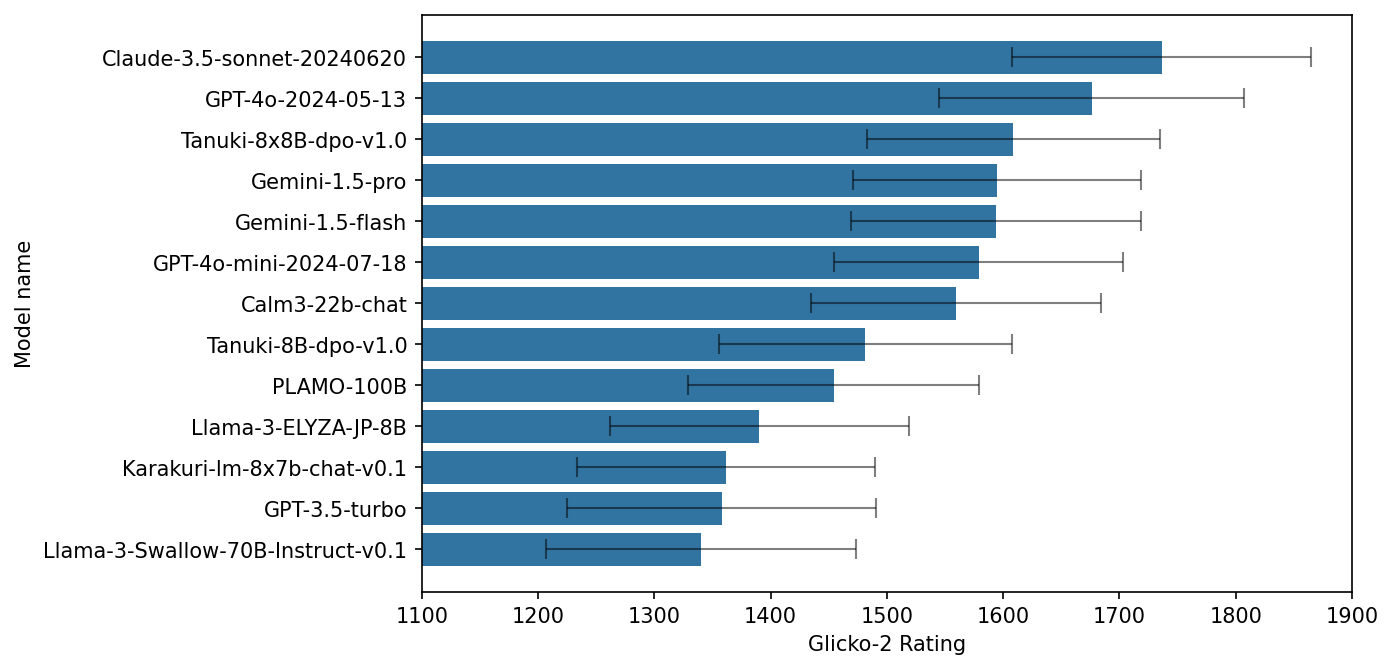

In [50]:
#2sigmaでのグラフ
df=pd.DataFrame(sorted_data)
plt.figure(figsize=(8,5),dpi=150)
sns.barplot(x="rating",y="name",data=df)
#エラーバーを表示. プロットは打たない
plt.errorbar(df["rating"],df["name"],xerr=df["rd"]*2,fmt='None',color='black',capsize=5,elinewidth=1,alpha=0.5)
plt.xlim(1100,1900)
plt.xlabel("Glicko-2 Rating")
plt.ylabel("Model name")

Text(0, 0.5, 'Model name')

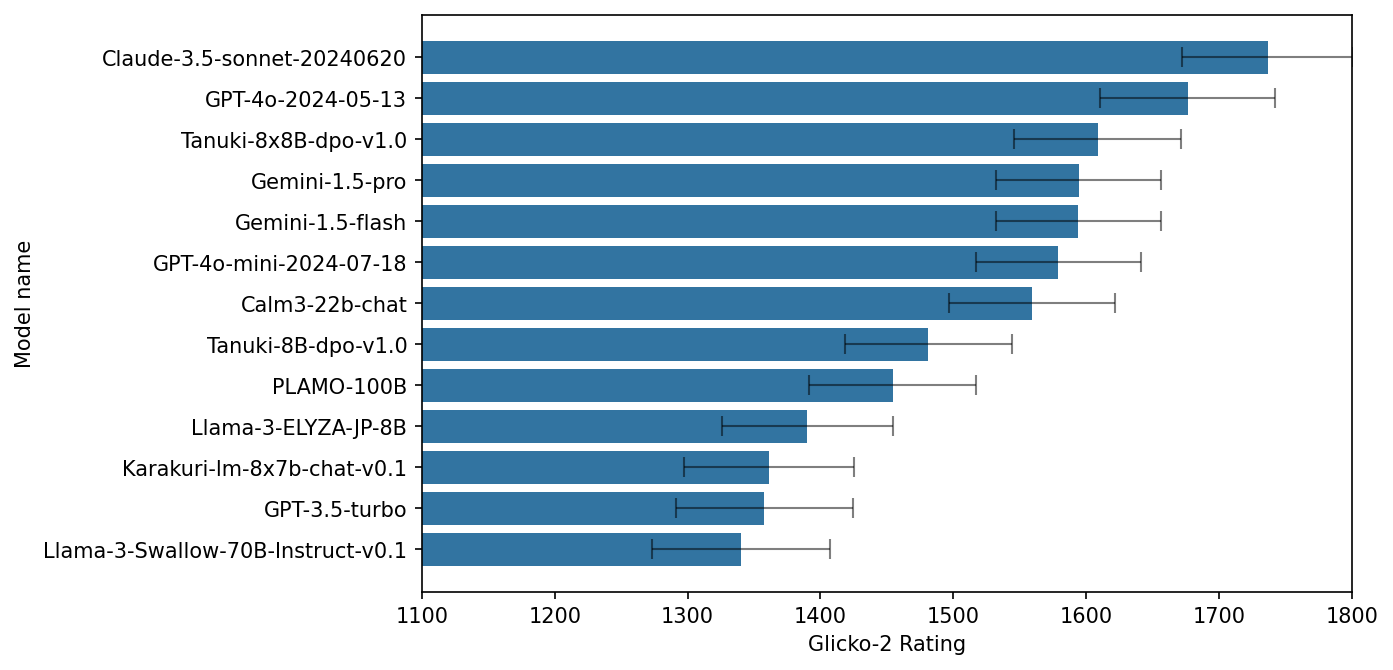

In [51]:
#1sigmaでのグラフ
df=pd.DataFrame(sorted_data)
plt.figure(figsize=(8,5),dpi=150)
sns.barplot(x="rating",y="name",data=df)
#エラーバーを表示. プロットは打たない
plt.errorbar(df["rating"],df["name"],xerr=df["rd"],fmt='None',color='black',capsize=5,elinewidth=1,alpha=0.5)
plt.xlim(1100,1800)
plt.xlabel("Glicko-2 Rating")
plt.ylabel("Model name")

In [53]:
#信頼区間での順位を予測
import copy

df=pd.DataFrame(sorted_data)
df["lowerst_rank"]=0
df["highest_rank"]=0
model_list=df["name"].tolist()


for model in model_list:
    df_lowest=copy.deepcopy(df)
    #当該モデルにとって最も悲観的なレーティングを設定
    df_lowest["rating"]=df_lowest["upper_bound"]
    df_lowest.loc[df_lowest["name"] == model, "rating"] = df_lowest.loc[df_lowest["name"] == model, "lower_bound"]

    #レーティング順にソート
    df_lowest=df_lowest.sort_values("rating",ascending=False).reset_index(drop=True)
    
    #当該モデルの順位を取得
    rank=df_lowest[df_lowest["name"]==model].index[0]+1
    df.loc[df["name"]==model,"lowerst_rank"]=rank

    #当該モデルにとって最も楽観的なレーティングを設定
    df_highest=copy.deepcopy(df)
    df_highest["rating"]=df_highest["lower_bound"]
    df_highest.loc[df_highest["name"] == model, "rating"] = df_highest.loc[df_highest["name"] == model, "upper_bound"]

    #レーティング順にソート
    df_highest=df_highest.sort_values("rating",ascending=False).reset_index(drop=True)

    #当該モデルの順位を取得
    rank=df_highest[df_highest["name"]==model].index[0]+1
    df.loc[df["name"]==model,"highest_rank"]=rank

df.sort_values("win_rate",ascending=False)

,name,name_original,win_rate,total_battle_count,rating,rd,lower_bound,upper_bound,lowerst_rank,highest_rank
1,GPT-4o-2024-05-13,gpt-4o-2024-05-13,0.582996,247,1676.292786,65.594876,1610.697910,1741.887662,7,1
0,Claude-3.5-sonnet-20240620,claude-3-5-sonnet-20240620,0.565657,198,1736.501968,64.257805,1672.244163,1800.759774,2,1
3,Gemini-1.5-pro,gemini-1.5-pro,0.500000,170,1594.427493,61.951018,1532.476475,1656.378511,8,2
4,Gemini-1.5-flash,gemini-1.5-flash,0.433884,242,1594.193489,62.398824,1531.794665,1656.592313,8,2
5,GPT-4o-mini-2024-07-18,gpt-4o-mini-2024-07-18,0.430769,260,1579.114733,62.170264,1516.944470,1641.284997,8,2
2,Tanuki-8x8B-dpo-v1.0,team-hatakeyama-phase2/Tanuki-8x8B-dpo-v1.0,0.410334,329,1608.675297,63.020981,1545.654316,1671.696279,7,2
6,Calm3-22b-chat,cyberagent/calm3-22b-chat,0.382789,337,1559.095991,62.415264,1496.680726,1621.511255,9,2
7,Tanuki-8B-dpo-v1.0,weblab-GENIAC/Tanuki-8B-dpo-v1.0,0.284848,330,1481.259756,62.997012,1418.262744,1544.256768,12,4
8,PLAMO-100B,plamo-beta,0.282787,244,1454.209044,62.705443,1391.503601,1516.914487,13,7
10,Karakuri-lm-8x7b-chat-v0.1,karakuri-ai/karakuri-lm-8x7b-chat-v0.1,0.224138,290,1361.166691,64.095493,1297.071198,1425.262184,13,8
